In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import numpy as np
import os
import torch.nn as nn
from tqdm import tqdm
import json
from functools import partial
from torch import einsum, nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from einops import pack, rearrange, reduce, repeat, unpack


In [4]:
def findAllFile(base):
    file_path = []
    for root, ds, fs in os.walk(base, followlinks=True):
        for f in fs:
            fullname = os.path.join(root, f)
            file_path.append(fullname)
    return file_path



In [5]:
# from utils.motion_processing.hml_process import recover_from_ric, recover_root_rot_pos,recover_from_rot
import utils.vis_utils.plot_3d_global as plot_3d
import matplotlib.pyplot as plt

def vis(mot , dset , name = "motion"):

    if isinstance(mot , torch.Tensor):
        mot = dset.toMotion(mot)
    mot =dset.inv_transform(mot)



    xyz = np.array(dset.to_xyz(mot).cpu())

    print(xyz.shape)

    
    plot_3d.render(xyz , f"/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/{name}.gif")

## VQVAE

In [6]:
from configs.config import cfg, get_cfg_defaults


In [7]:
def load_vqvae(gen_cfg):

    if gen_cfg.vqvae.body_config is not None:

        body_cfg = get_cfg_defaults()
        body_cfg.merge_from_file(gen_cfg.vqvae.body_config)
        body_model = (
            instantiate_from_config(body_cfg.vqvae).to(device).eval()
        )
        body_model.load(os.path.join(body_cfg.output_dir, "vqvae_motion.pt"))
    else:
        body_model = None
    
    if gen_cfg.vqvae.left_hand_config is not None:
        left_cfg = get_cfg_defaults()
        left_cfg.merge_from_file(gen_cfg.vqvae.left_hand_config)
        left_hand_model = instantiate_from_config(left_cfg.vqvae).to(device).eval()
        left_hand_model.load(
            os.path.join(left_cfg.output_dir, "vqvae_motion.pt")
        )
    else:
        left_hand_model = None
        
    if gen_cfg.vqvae.right_hand_config is not None:
        right_cfg = get_cfg_defaults()
        right_cfg.merge_from_file(gen_cfg.vqvae.right_hand_config)
        right_hand_model = instantiate_from_config(right_cfg.vqvae).to(device).eval()
        right_hand_model.load(
            os.path.join(right_cfg.output_dir, "vqvae_motion.pt")
        )
    else:
        right_hand_model = None

    return body_model, left_hand_model , right_hand_model , body_cfg , left_cfg , right_cfg

In [26]:
def bkn_to_motion(codes, dset):
        # codes b k n
        
        k = codes.shape[1]
        if body_model is not None:
            body_inds = codes[:, 0]
            body_motion = body_model.decode(body_inds[0:1]).detach().cpu()
            
    
            if "g" in dataset_args.hml_rep:
                z = torch.zeros(
                    body_motion.shape[:-1] + (2,),
                    dtype=body_motion.dtype,
                    device=body_motion.device,
                )
                body_motion = torch.cat(
                    [body_motion[..., 0:1], z, body_motion[..., 1:]], -1
                )
    
            body_M = dset.toMotion(
                body_motion[0],
                motion_rep=MotionRep("body"),
                hml_rep=body_cfg.dataset.hml_rep,
            )

        if k == 2:
            left_inds = codes[:, 0]
            right_inds = codes[:, 1]

            left_motion = left_hand_model.decode(left_inds[0:1]).detach().cpu()
            right_motion = right_hand_model.decode(right_inds[0:1]).detach().cpu()

            left_M = dset.toMotion(
                left_motion[0],
                motion_rep=MotionRep(left_cfg.dataset.motion_rep),
                hml_rep=left_cfg.dataset.hml_rep,
            )
            right_M = dset.toMotion(
                right_motion[0],
                motion_rep=MotionRep(right_cfg.dataset.motion_rep),
                hml_rep=right_cfg.dataset.hml_rep,
            )
            hand_M = left_M + right_M
            hand_M.motion_rep = MotionRep.HAND
            hand_M.hml_rep = ''.join(set(left_M.hml_rep).intersection(right_M.hml_rep))
            # full_M = dset.to_full_joint_representation(body_M, left_M, right_M)
            return hand_M
            
            
        if k == 3:
            left_inds = codes[:, 1]
            right_inds = codes[:, 2]
            
            left_motion = left_hand_model.decode(left_inds[0:1]).detach().cpu()
            right_motion = right_hand_model.decode(right_inds[0:1]).detach().cpu()
        
            left_M = dset.toMotion(
                left_motion[0],
                motion_rep=MotionRep("left_hand"),
                hml_rep=left_cfg.dataset.hml_rep,
            )
            right_M = dset.toMotion(
                right_motion[0],
                motion_rep=MotionRep("right_hand"),
                hml_rep=right_cfg.dataset.hml_rep,
            )
            full_M = dset.to_full_joint_representation(body_M, left_M, right_M)
            return full_M

        return body_M

## Motion Gen

In [ ]:
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider, ConditionFuser
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.generation.motion_generator import Transformer, MotionMuse
from core.models.utils import instantiate_from_config, get_obj_from_str


In [ ]:
from configs.config_t2m import cfg, get_cfg_defaults
from configs.config import get_cfg_defaults as get_cfg_defaults3

cfg = get_cfg_defaults()
cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_generation/motion_generation.yaml")
cfg.freeze()
mmuse_args = cfg.motion_generator
dataset_args = cfg.dataset


In [ ]:
target = mmuse_args.pop("target")
motion_muse = MotionMuse(mmuse_args).to(device).eval()

In [ ]:
from core.models.resnetVQ.vqvae import HumanVQVAE

In [ ]:

vcfg = get_cfg_defaults3()
vcfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/vqvae/vqvae_body_gprvc/vqvae_body_gprvc.yaml")
vqvae_args = vcfg.vqvae
vqvae_args.nb_joints = 22
vqvae_args.motion_dim = 263

In [ ]:
np.split(np.cusum)

In [ ]:
vqvae_model = HumanVQVAE(vqvae_args).to(device).eval()
vqvae_model.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ACMG/checkpoints/smplx_resnet/vqvae_motion.pt")

In [ ]:
condition_provider = ConditionProvider(
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            audio_padding=dataset_args.audio_padding,
            motion_max_length_s=10,
            audio_max_length_s=10,
            pad_id = motion_muse.transformer.pad_token_id,
            fps=30/4
        )

In [ ]:
# bod_ind = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/indices/body/aist/subset_0000/Dance_Break_3_Step_clip_1.npy")
# lh_ind = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/indices/left_hand/aist/subset_0000/Dance_Break_3_Step_clip_1.npy")
# rh_ind = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/indices/right_hand/aist/subset_0000/Dance_Break_3_Step_clip_1.npy")

In [ ]:
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate

dset = MotionIndicesAudioTextDataset("animation" , "/srv/hays-lab/scratch/sanisetty3/motionx" ,motion_rep = "full", split = "train" , fps = 30/4  )

In [ ]:
inpss  = next(iter(dset))

In [ ]:
train_ds, sampler_train, weights_train  = load_dataset_gen(dataset_args=dataset_args, split = "train" , dataset_names = ["animation" , "choreomaster" ] )

In [ ]:
train_loader = torch.utils.data.DataLoader(
        dset,
        4,
        # sampler=sampler_train,
        # shuffle = False,
        collate_fn=partial(simple_collate , conditioner = condition_provider),
        drop_last=True,
    )

In [ ]:
for inputs, conditions in train_loader:
    break
    

In [ ]:
inputs["motion"][0].shape

In [ ]:
inputs["motion"][1].shape

In [ ]:
conditions["audio"][0].shape

In [ ]:
conditions["text"][0].shape

In [ ]:
motions = inputs["motion"][0].squeeze().to(torch.long)
motion_mask = inputs["motion"][1]

In [ ]:
fuse_method = {"cross": ["audio"], "prepend": ["text"]}
condition_fuser = ConditionFuser(fuse_method)

In [ ]:
audio_embed = self.project_audio(conditions["audio"][0])
text_embed = self.project_text(conditions["text"][0])

inputs_, cross_inputs = self.condition_fuser(
    input,
    {
        "text": (text_embed, conditions["text"][1]),
        "audio": (audio_embed, conditions["audio"][1]),
    },
)

## Muse gen

In [10]:
from core import MotionTokenizerParams, pattern_providers

from core.param_dataclasses import pattern_providers
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.utils import instantiate_from_config, get_obj_from_str
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider,ConditionFuser
from core.models.generation.muse import MLMModel, MotionMuse
import einops
from configs.config_t2m import get_cfg_defaults as muse_get_cfg_defaults

from core.datasets.text_encoders import BERTConditioner, ClipConditioner, T5Conditioner, parse_prompt_attention
from core.datasets.audio_encoders import EncodecConditioner, LibrosaConditioner

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
gen_cfg = muse_get_cfg_defaults()
gen_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse/motion_muse.yaml")
gen_cfg.freeze()

KeyError: 'Non-existent config key: motion_generator.causal'

In [ ]:
tranformer_config = gen_cfg.motion_generator
fuse_config = gen_cfg.fuser
pattern_config = gen_cfg.codebooks_pattern
dataset_args = gen_cfg.dataset

target = tranformer_config.pop("targe
motion_gen = MotionMuse(tranformer_config , fuse_config , pattern_config).to(device)
# motion_gen = torch.compile(motion_gen)
# pkg = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse_constant/checkpoints/motion_muse.70000.pt", map_location="cuda")
# motion_gen.load_state_dict(pkg["model"])

In [8]:
# ds, _, _  = load_dataset_gen(dataset_names = ["animation"] , dataset_args=dataset_args, split = "render")


In [9]:
motion_gen = MotionMuse(tranformer_config , fuse_config , pattern_config).to(device)
# pkg = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse/motion_muse.pt", map_location="cuda")
# motion_gen.load_state_dict(pkg["model"])

NameError: name 'tranformer_config' is not defined

In [ ]:
_, conditions = condition_provider(raw_audio= None, raw_text="a person doing kung fu kick and then jumping")
_, neg_conditions = condition_provider(raw_text="")
gen_ids = motion_gen.generate(conditions =conditions, neg_conditions = None, duration_s = 30, temperature = 0.2 ,timesteps=18, cond_scale = 8)


## MotionMuse

In [9]:
from core import MotionTokenizerParams, pattern_providers

from core.param_dataclasses import pattern_providers
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.utils import instantiate_from_config, get_obj_from_str
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider,ConditionFuser
from core.models.generation.muse import MLMModel, MotionMuse
import einops
from configs.config_t2m import get_cfg_defaults as muse_get_cfg_defaults
from core import MotionTokenizerParams

from core.datasets.text_encoders import BERTConditioner, ClipConditioner, T5Conditioner, parse_prompt_attention
from core.datasets.audio_encoders import EncodecConditioner, LibrosaConditioner

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def getBodyMuse(nme = "motion_muse_film"):
    gen_cfg = muse_get_cfg_defaults()
    gen_cfg.merge_from_file(f"/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/{nme}/{nme}.yaml")
    gen_cfg.freeze()
    
    tranformer_config = gen_cfg.motion_generator
    fuse_config = gen_cfg.fuser
    pattern_config = gen_cfg.codebooks_pattern
    
    target = tranformer_config.pop("target")
    motion_gen = MotionMuse(tranformer_config , fuse_config , pattern_config).to(device).eval()
    pkg = torch.load(f"/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/{nme}/motion_muse.pt", map_location="cuda")
    motion_gen.load_state_dict(pkg["model"])
    return motion_gen


In [11]:
gen_cfg = muse_get_cfg_defaults()
gen_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse_hands/motion_muse_hands.yaml")
gen_cfg.freeze()

tranformer_config = gen_cfg.motion_generator
fuse_config = gen_cfg.fuser
pattern_config = gen_cfg.codebooks_pattern
dataset_args = gen_cfg.dataset

target = tranformer_config.pop("target")
motion_gen = MotionMuse(tranformer_config , fuse_config , pattern_config).to(device)


Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [30]:
# motion_gen = MotionMuse(tranformer_config , fuse_config , pattern_config).to(device)
# motion_gen = torch.compile(motion_gen)
# pkg = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse_film/motion_muse.pt", map_location="cuda")
# motion_gen.load_state_dict(pkg["model"])

In [31]:
body_muse = getBodyMuse("motion_muse_film")

In [12]:
body_model, left_hand_model , right_hand_model , body_cfg , left_cfg , right_cfg = load_vqvae(gen_cfg)

In [13]:
condition_provider = ConditionProvider(
            text_conditioner_name = dataset_args.text_conditioner_name,
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            audio_padding=dataset_args.audio_padding,
            motion_max_length_s=dataset_args.motion_max_length_s,
            audio_max_length_s=dataset_args.audio_max_length_s,
            pad_id = MotionTokenizerParams(tranformer_config.num_tokens).pad_token_id,
            fps=30/4,
            # only_motion = True
            # device = "cpu"
        )

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [14]:
# dset = MotionIndicesAudioTextDataset("animation" , "/srv/hays-lab/scratch/sanisetty3/motionx" ,hml_rep = "gpvc" , window_size_s=4, motion_rep = "body", split = "train" , fps = 30/4  )


In [15]:
# dset[0]["motion"].shape

In [16]:
train_ds, sampler_train, weights_train  = load_dataset_gen(dataset_names = ["animation" , "choreomaster"] , dataset_args=dataset_args, split = "train")


Total number of motions animation: 120 and texts 120
Total number of motions choreomaster: 34 and texts 34


In [17]:
train_loader = torch.utils.data.DataLoader(
        train_ds,
        4,
        sampler=sampler_train,
        # shuffle = False,
        collate_fn=partial(simple_collate , conditioner = condition_provider , permute = True),
        # drop_last=True,
    )

In [18]:
for inputs, conditions in (train_loader):
    break
    

In [19]:
inputs["names"]

array(['choreomaster/1303', 'animation/subset_0000/Ways_To_Catch_A_Fly',
       'animation/subset_0002/Ways_To_Pick_Up_A_Dollar_Pop_And_Lock',
       'animation/subset_0002/Ways_To_Open_A_Christmas_Gift_Carefully'],
      dtype='<U61')

In [20]:
conditions["audio"][0].shape

torch.Size([4, 120, 128])

In [21]:
conditions["text"][0].shape

torch.Size([4, 41, 1024])

In [22]:
inputs["motion"][0].shape

torch.Size([4, 2, 30])

In [23]:
mask = inputs["motion"][1]

In [43]:
out2 = body_muse((inputs["motion"][0][:,:1,:] , mask) , conditions , train_critic = False)

In [44]:
conditions["body"] = (out2.embed , mask)

In [45]:
motion_gen.model.condition_fuser.cond2fuse

{'body': 'cross'}

In [46]:
_ = conditions.pop("audio")
_ = conditions.pop("text")

In [47]:
conditions["body"][0].shape

torch.Size([4, 30, 512])

In [24]:
out = motion_gen((inputs["motion"][0] , mask) , conditions)

In [25]:
out.logits.shape

torch.Size([4, 2, 30, 512])

In [49]:
with torch.no_grad():
    motion_gen = motion_gen.eval()
    gen_ids = motion_gen.generate(conditions =conditions, neg_conditions = None, duration_s = 4, temperature = 0.2 ,timesteps=18, cond_scale = 8)

['body']


100%|███████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 86.36it/s]


In [101]:
gen_ids.shape

torch.Size([4, 3, 30])

In [57]:
motions_ids = inputs["motion"][0].cuda()
B, K, T = motions_ids.shape

In [73]:
hand_ids = motions_ids[: , 1: , :]

In [74]:
gt_motion = bkn_to_motion(hand_ids[0:1], train_ds.datasets[0])

In [75]:
print(gt_motion)

motion representation: hand, type: rpv, num joints: 30, dim: 360


In [76]:
gen_motion = bkn_to_motion(gen_ids[0:1], train_ds.datasets[0])

In [77]:
gen_motion.dim

360

In [79]:
train_ds.datasets[0].render_hml(
                    gen_motion,
                    "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/gen_hand.gif",
    zero_orient = True,
    zero_trans=  True,
                )

In [45]:
b = 4
d = 2
m = torch.randn((b , 100, 4)).to(device)

In [46]:
num_masked_d = torch.Tensor(np.random.choice([0, 1, 2], size= b , p = [0.5 , 0.3 , 0.2])).to(device)


In [47]:
num_masked_d

tensor([1., 2., 2., 1.], device='cuda:0')

In [48]:
batch_randperm2 = torch.rand((b, d), device=device).argsort(dim=-1)

In [49]:
mask2 = ~(batch_randperm2 < rearrange(num_masked_d, "b -> b 1"))

In [50]:
m[...,2:] = m[...,2:] * mask2[:, None, :]

In [57]:
m[-1]

tensor([[ 0.5423,  0.0217,  0.0000, -2.3568],
        [-1.4833, -0.7582, -0.0000, -0.7991],
        [ 1.5539, -0.4067,  0.0000,  1.0742],
        [-0.3373,  0.0125,  0.0000,  1.5257],
        [ 1.2751, -0.5040, -0.0000,  0.6759],
        [ 1.4524,  0.2557, -0.0000, -0.6097],
        [-0.3757,  0.5723, -0.0000, -0.2843],
        [-0.8842, -0.0878,  0.0000, -0.9985],
        [ 0.1491, -0.6671, -0.0000, -1.7118],
        [-1.5073,  0.0763,  0.0000,  0.4417],
        [-0.4763, -1.4867,  0.0000, -0.8881],
        [-1.2453, -0.6286,  0.0000, -0.3653],
        [-1.0039, -0.4574,  0.0000, -0.1296],
        [-0.9691, -1.8120, -0.0000, -0.9129],
        [ 1.6117, -0.2085,  0.0000, -0.5991],
        [ 0.7289,  0.1887, -0.0000,  1.5866],
        [ 1.0475,  1.3273,  0.0000,  2.0945],
        [ 0.5280, -0.3461, -0.0000, -1.0705],
        [-1.1033,  0.4504,  0.0000, -0.3862],
        [ 0.7701, -0.9985,  0.0000, -0.1028],
        [ 0.7797, -0.1886, -0.0000, -0.8403],
        [ 0.3608, -1.3319,  0.0000

In [ ]:

to_mask = random.random() > 0.4
if to_mask:

    batch_randperm1 = torch.rand((b, n), device=device).argsort(dim=-1)
    batch_randperm2 = torch.rand((b, d), device=device).argsort(dim=-1)

    mask1 = ~(batch_randperm1 < rearrange(num_masked_n, "b -> b 1"))
    mask2 = ~(batch_randperm2 < rearrange(num_masked_d, "b -> b 1"))

    # motion = motion * mask1[:, :, None]
    motion = motion * mask2[:, None, :]

## Translation transformer

In [11]:
from core.datasets.translation_dataset import TranslationDataset, load_dataset, simple_collate
from core.datasets.conditioner import ConditionProvider
import einops
from configs.config_t2o import get_cfg_defaults as trans_get_cfg_defaults
from core.models.utils import instantiate_from_config

from utils.motion_processing.quaternion import qinv, qrot, quaternion_to_cont6d
import utils.rotation_conversions as geometry

from core.models.generation.translation_transformer import TranslationTransformer

In [7]:
def quaternion_to_angle_axis(q):
    """
    Convert quaternion to angle-axis representation.
    """
    q0, q1, q2, q3 = q
    angle = 2 * np.arccos(q0)
    axis = np.array([q1, q2]) / np.sqrt(1 - q0**2)
    return angle, axis

def visualize_orientations_2d(points, orientations):
    plt.figure(figsize=(8, 6))

    # Plot points
    plt.scatter(points[:, 0], points[:, 1], c='b', marker='o', label='Points')

    # Plot orientation vectors
    for i in range(len(points)):
        origin = points[i]
        orientation_quaternion = orientations[i]
        angle, axis = quaternion_to_angle_axis(orientation_quaternion)
        dx, dy = axis * angle
        plt.quiver(*origin, dx, dy, scale=1, color='r')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Orientation Visualization in 2D')
    plt.legend()
    plt.grid()
    plt.axis('equal')
    plt.show()

In [10]:
t_cfg = trans_get_cfg_defaults()
t_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/simple_motion_translation/simple_motion_translation.yaml")
# t_cfg.freeze()

tcn_config = t_cfg.vqvae
dataset_args = t_cfg.dataset

In [34]:
from core.models.generation.translator import Traj2Orient


In [35]:
# from core.models.generation.translation_transformer import TranslationTransformer
# trans_former = TranslationTransformer(tranformer_config, fuse_config).to(device)

In [85]:
# trans_former.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_translation/translation_transformer.pt")

In [47]:

def recover_root_rot_pos(data):
    rot_vel = data[..., 0]
    r_rot_ang = torch.zeros_like(rot_vel).to(data.device)
    """Get Y-axis rotation from rotation velocity"""
    r_rot_ang[..., 1:] = rot_vel[..., :-1]
    r_rot_ang = torch.cumsum(r_rot_ang, dim=-1)

    r_rot_quat = torch.zeros(data.shape[:-1] + (4,)).to(data.device)
    r_rot_quat[..., 0] = torch.cos(r_rot_ang)
    r_rot_quat[..., 2] = torch.sin(r_rot_ang)

    r_pos = torch.zeros(data.shape[:-1] + (3,)).to(data.device)
    data = data.to(torch.float)
    r_pos[..., 1:, [0, 2]] = data[..., :-1, 1:3]
    """Add Y-axis rotation to root position"""
    r_pos = qrot(qinv(r_rot_quat), r_pos)

    r_pos = torch.cumsum(r_pos, dim=-2)

    r_pos[..., 1] = data[..., 3]
    return r_rot_quat, r_pos

In [9]:
# # r_rot_quats= []
# r_poss = []
# all_mots = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs")
# for pth in tqdm(all_mots):
#     root = np.load(pth)[: , :4]
#     if root.shape[0] < 30:
#         continue
#     r_rot_quat, r_pos = recover_root_rot_pos(torch.Tensor(root))
#     rel_pos = np.zeros_like(r_pos)
#     rel_pos[..., 1:, [0, 2]] = r_pos[..., 1:, [0, 2]] - r_pos[..., :-1, [0, 2]]
    
#     # r_rot_quats.append(r_rot_quat.numpy())
#     r_poss.append(rel_pos)
# # concat_rot = np.concatenate(r_rot_quats , 0)
# concat_r_pos = np.concatenate(r_poss , 0)
# Mean = concat_r_pos.mean(axis=0)
# Std = concat_r_pos.std(axis=0)
# np.save("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/Mean_rel_pos.npy" , Mean )
# np.save("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/Std_rel_pos.npy" , Std )   

In [12]:
# condition_provider = ConditionProvider(
#             text_conditioner_name = dataset_args.text_conditioner_name,
#             motion_rep=MotionRep(dataset_args.motion_rep),
#             audio_rep=AudioRep(dataset_args.audio_rep),
#             text_rep=TextRep(dataset_args.text_rep),
#             motion_padding=dataset_args.motion_padding,
#             audio_padding=dataset_args.audio_padding,
#             motion_max_length_s=dataset_args.motion_max_length_s,
#             audio_max_length_s=dataset_args.audio_max_length_s,
#             fps=30,
#             # device = "cpu"
#         )

condition_provider = ConditionProvider(
            # motion_rep=self.dataset_args.motion_rep,
            # motion_padding=dataset_args.motion_padding,
            # motion_max_length_s=dataset_args.motion_max_length_s,
            only_motion=True,
        )

In [13]:
# mean_rot = np.load(os.path.join("/srv/hays-lab/scratch/sanisetty3/motionx", "motion_data/Mean_rots.npy"))
# std_rot = np.load(os.path.join("/srv/hays-lab/scratch/sanisetty3/motionx", "motion_data/Std_rots.npy"))

In [14]:
train_ds, sampler_train, weights_train  = load_dataset(dataset_names = ["animation" , "choreomaster"], dataset_args=dataset_args, split = "train")


Total number of motions animation: 120
Total number of motions choreomaster: 34


In [15]:
train_loader = torch.utils.data.DataLoader(
        train_ds,
        4,
        sampler=sampler_train,
        # shuffle = False,
        collate_fn=partial(simple_collate , conditioner = condition_provider),
        # drop_last=True,
    )

In [16]:
for inputs in (train_loader):
    break
    

In [17]:
inputs["names"]

array(['choreomaster/5034.npy',
       'animation/subset_0000/Ways_To_Enter_A_Room_Horror_Movie.npy',
       'choreomaster/1090.npy', 'choreomaster/1033.npy'], dtype='<U59')

In [55]:
# def standardize_along_seq(data):
#     # Calculate mean and standard deviation along seq_len dimension
#     mean = torch.mean(data, axis=1, keepdims=True)
#     std_dev = torch.std(data, axis=1, keepdims=True)

#     # Standardize the data
#     standardized_data = (data - mean) / std_dev

#     return standardized_data


# fig = plt.figure(figsize=(4,4))
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
# axes[0].plot(ln_pos[0 , :,0].numpy(), ln_pos[0,:,1].numpy())
# axes[1].plot(ln_pos[2 , :,0].numpy(), ln_pos[2,:,1].numpy())
# fig.tight_layout()

In [18]:
motion = inputs["motion"][0]


In [19]:
motion.shape

torch.Size([4, 120, 7])

In [21]:
model = instantiate_from_config(tcn_config)

In [24]:
out = model(motion)

In [54]:
motion = inputs["motion"][0]
mask = inputs["motion"][1].to(torch.bool)
r_rot = motion[..., :4]
r_pos = motion[..., 4:]
r_pos = r_pos[..., [0, 2]]
rel_pos = torch.zeros_like(r_pos)
rel_pos[:,1:] = r_pos[:,1:] - r_pos[:,:-1]

In [69]:
r_rot1 = geometry.quaternion_to_axis_angle(r_rot)[..., 1:2]
r_rot6 = geometry.matrix_to_rotation_6d(geometry.quaternion_to_matrix(r_rot))

In [55]:
r_rot2= geometry.quaternion_to_matrix(r_rot)[... , [0,0] , [0,2]]

In [65]:
rel_pos.shape

torch.Size([4, 120, 2])

In [57]:
rel_pos.mean(dim = [1,2])

tensor([ 0.0000e+00,  6.3957e-04, -4.0751e-06,  1.0767e-03])

In [68]:
rel_pos.std(dim = [1,2])

tensor([0.0000, 0.0070, 0.0021, 0.0121])

In [178]:
mot = torch.cat([rel_pos , r_rot2 ] , -1).to(device)

In [75]:
b , n , d = mot.shape

In [213]:
import math
import random
rand_time = torch.zeros((b,), device=device).float().uniform_(1, 1)
rand_mask_probs = torch.cos(rand_time * math.pi * 0.5)
num_token_masked = (n * rand_mask_probs).round().clamp(min=1)
num_attr_masked = torch.Tensor(np.random.choice([0,1,2] , b)).to(device)

In [214]:
batch_randperm1 = torch.rand((b, n), device=device).argsort(dim=-1)
batch_randperm2 = torch.rand((b, d), device=device).argsort(dim=-1)

mask1 = ~(batch_randperm1 < rearrange(num_token_masked, "b -> b 1"))
mask2 = ~(batch_randperm2 < rearrange(num_attr_masked, "b -> b 1"))


In [215]:
num_token_masked

tensor([1., 1., 1., 1.], device='cuda:0')

In [201]:
mot[0].shape

torch.Size([120, 4])

In [207]:
mot[2]*mask2[2][None, :]

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
        [-0.0000e+00, -1.6002e-03,  9.9995e-01,  9.5618e-03],
        [-0.0000e+00, -1.6319e-03,  9.9982e-01,  1.9105e-02],
        [-0.0000e+00, -1.4642e-03,  9.9959e-01,  2.8614e-02],
        [-0.0000e+00, -1.5240e-03,  9.9928e-01,  3.8072e-02],
        [-0.0000e+00, -1.4864e-03,  9.9887e-01,  4.7460e-02],
        [-0.0000e+00, -1.3501e-03,  9.9839e-01,  5.6761e-02],
        [-0.0000e+00, -1.1363e-03,  9.9782e-01,  6.5957e-02],
        [-0.0000e+00, -1.1483e-03,  9.9718e-01,  7.5029e-02],
        [-0.0000e+00, -1.1490e-03,  9.9647e-01,  8.3958e-02],
        [-0.0000e+00, -1.1844e-03,  9.9569e-01,  9.2724e-02],
        [-0.0000e+00, -1.2319e-03,  9.9486e-01,  1.0131e-01],
        [-0.0000e+00, -1.2478e-03,  9.9397e-01,  1.0969e-01],
        [-0.0000e+00, -1.2103e-03,  9.9303e-01,  1.1786e-01],
        [-0.0000e+00, -1.2496e-03,  9.9206e-01,  1.2578e-01],
        [-0.0000e+00, -1.2321e-03,  9.9106e-01,  1.3344e-01],
        

In [209]:
mot[2]

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
        [-1.7758e-04, -1.6002e-03,  9.9995e-01,  9.5618e-03],
        [-1.8272e-04, -1.6319e-03,  9.9982e-01,  1.9105e-02],
        [-2.7071e-04, -1.4642e-03,  9.9959e-01,  2.8614e-02],
        [-3.7155e-04, -1.5240e-03,  9.9928e-01,  3.8072e-02],
        [-3.8422e-04, -1.4864e-03,  9.9887e-01,  4.7460e-02],
        [-3.5175e-04, -1.3501e-03,  9.9839e-01,  5.6761e-02],
        [-3.6600e-04, -1.1363e-03,  9.9782e-01,  6.5957e-02],
        [-2.9120e-04, -1.1483e-03,  9.9718e-01,  7.5029e-02],
        [-2.8702e-04, -1.1490e-03,  9.9647e-01,  8.3958e-02],
        [-2.9273e-04, -1.1844e-03,  9.9569e-01,  9.2724e-02],
        [-3.0042e-04, -1.2319e-03,  9.9486e-01,  1.0131e-01],
        [-3.0298e-04, -1.2478e-03,  9.9397e-01,  1.0969e-01],
        [-2.9693e-04, -1.2103e-03,  9.9303e-01,  1.1786e-01],
        [-3.0327e-04, -1.2496e-03,  9.9206e-01,  1.2578e-01],
        [-3.0045e-04, -1.2321e-03,  9.9106e-01,  1.3344e-01],
        

In [195]:
~mask2[:, None , :]

tensor([[[ True,  True,  True,  True]],

        [[ True,  True,  True, False]],

        [[False,  True,  True,  True]],

        [[ True,  True, False,  True]]], device='cuda:0')

In [69]:
r_rot2.mean(dim = [1,2])

tensor([0.5503, 0.5042, 0.5380, 0.4690])

In [70]:
r_rot2.std(dim = [1,2])

tensor([0.4450, 0.4968, 0.4598, 0.5303])

In [100]:
traj2orient = Traj2Orient(tcn_config)

In [104]:
optim = torch.optim.Adam(traj2orient.parameters() , lr = 2e-4)

In [109]:
for _ in tqdm(range(20000)):
    for inputs in (train_loader):
        loss, pred_orient = traj2orient(inputs["motion"])
        loss.backward()
        optim.step()
        optim.zero_grad()

    print(loss)

    

  0%|                                                                                   | 1/20000 [02:48<933:35:28, 168.05s/it]

tensor(0.0784, grad_fn=<MseLossBackward0>)


  0%|                                                                                  | 1/20000 [03:37<1210:02:53, 217.82s/it]


KeyboardInterrupt: 

In [101]:
loss, pred_orient = traj2orient(inputs["motion"])
# pred_rot = geometry.matrix_to_quaternion(geometry.rotation_6d_to_matrix(embed))

In [ ]:
Gama = np.zeros((len(Foot_contact), 5, 240))

# Frequency and Step Duration
for i in range(len(Foot_contact)):

    # Compute Step Duration,Tau, for every four joints : Left heel,Left toe,Right heel,Right toe
    Step_duration = np.zeros(np.shape(Foot_contact[i]))

    for j in range(0, Foot_contact[i].shape[1]):
        
        #limit  calculation most recent frames
        window = np.arange(max(j - 60, 0), min(j + 60, np.shape(Foot_contact[i])[1]))

        # compute the ratio of foot joints are up to the ratio of frames foot joint are down
        d = (Foot_contact[i, :, window] > 0).sum()  # count number of frames which Foot is on the floor
        u = (Foot_contact[i, :, window] < 0).sum()  # count number of frames which Foot isn't on the floor
        Step_duration[:, j] = ((np.pi * d) / (u + d))  # compute ratio
        Tau = np.cos(((np.pi * d) / (u + d)))  # See section 6.3

In [18]:
r_rot, r_pos = trans_former.recover_root_rot_pos(inputs["motion"][0])
traj = r_pos[...,[0,2]]

In [59]:
class CausalConv1d(nn.Module):
    def __init__(self, chan_in, chan_out, kernel_size, pad_mode = 'reflect', **kwargs):
        super().__init__()
        kernel_size = kernel_size
        dilation = kwargs.get('dilation', 1)
        stride = kwargs.get('stride', 1)
        self.pad_mode = pad_mode
        self.causal_padding = dilation * (kernel_size - 1) + (1 - stride)

        self.conv = nn.Conv1d(chan_in, chan_out, kernel_size, **kwargs)

    def forward(self, x):
        x = F.pad(x, (self.causal_padding, 0), mode = self.pad_mode)
        return self.conv(x)

In [61]:

class ResidualUnit(nn.Module):
    def __init__(self, chan_in, chan_out, dilation, kernel_size = 7, pad_mode = 'reflect'):
        super().__init__()
        self.net = nn.Sequential(
        CausalConv1d(chan_in, chan_out, kernel_size, dilation = dilation, pad_mode = pad_mode),
        nn.ELU(),
        CausalConv1d(chan_out, chan_out, 1, pad_mode = pad_mode),
        nn.ELU(),
    )

    def forward(self, x):
        return self.net(x) + x

In [69]:
a = CausalConv1d(2,64,7)
b= ResidualUnit(64,64,1 , 3)
c = CausalConv1d(64,2,3)


In [70]:
x = a(pos)
x = b(x)
x = c(x)

In [71]:
x.shape

torch.Size([4, 2, 120])

In [68]:

# a = nn.Conv1d(2, 64, 5, 1, "same")
# b = Resnet1D(64, 2, 3)
# c = nn.Conv1d(64, 2, 3, 1, "same")




In [53]:
x = a(pos)
x = b(x)
x = c(x)

In [54]:
x.shape

torch.Size([4, 2, 120])

In [19]:
class Encoder(nn.Module):
    def __init__(
        self,
        input_emb_width=2,
        out_dim=2,
        
        width=None,
        dilation_growth_rate=3,
        activation="relu",
        norm=None,
    ):
        super().__init__()

        blocks = []
        # filter_t, pad_t = stride_t * 2, stride_t // 2
        if width is None:
            width = codebook_dim

        blocks.append(nn.Conv1d(input_emb_width, width, 7, 1, 1))
        blocks.append(nn.ReLU())
        blocks.append(nn.Sequential(
                nn.Conv1d(input_dim, width, filter_t, stride_t, pad_t),
                Resnet1D(
                    width, depth, dilation_growth_rate, activation=activation, norm=norm
                ),
            ))

        
        blocks.append(nn.Conv1d(width, out_dim, 3, 1, 1))
        self.model = nn.Sequential(*blocks)

    def forward(self, x):
        return self.model(x)

In [80]:
# r_rot[1]

In [81]:
# r_rot_pred[1]

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/_tensor.py:945: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other


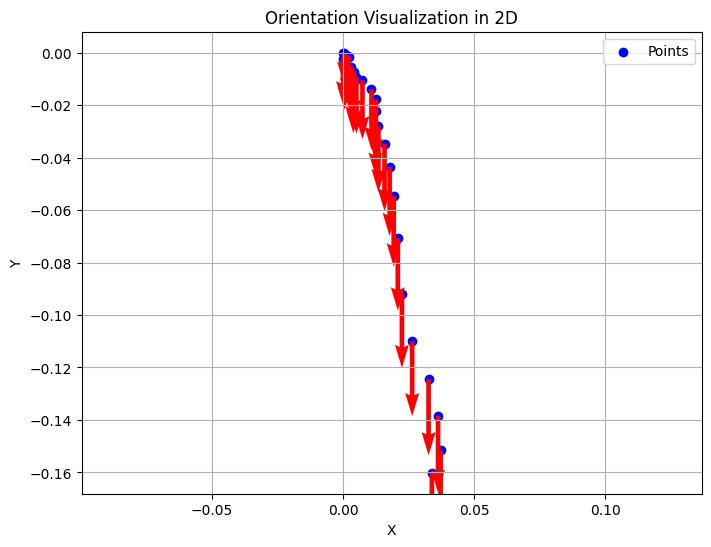

In [22]:
rp = r_pos[1 ,:30,[0,2]]
rp[:,1] = -rp[:,1] 
visualize_orientations_2d(rp.cpu(), r_rot[1].cpu())

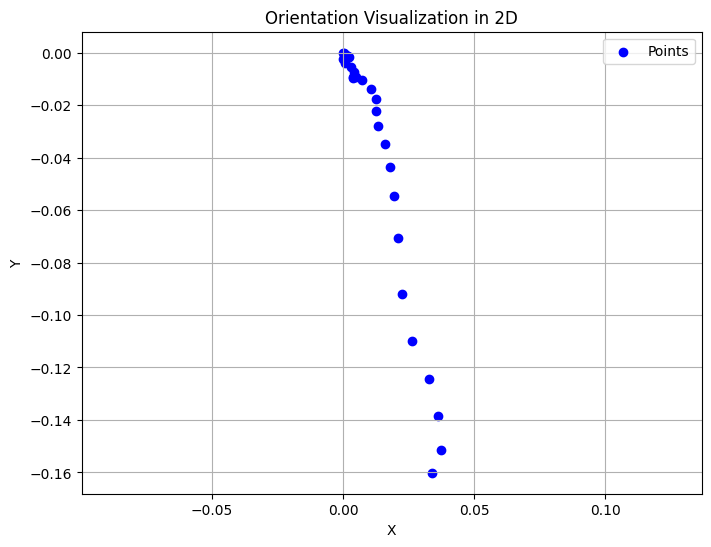

In [23]:
# rp = r_pos[1 ,:30,[0,2]]
# rp[:,1] = -rp[:,1] 
visualize_orientations_2d(rp.cpu(), r_rot_pred[1].cpu())

In [82]:
pose = torch.Tensor(np.load("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/smplx_322/idea400/subset_0056/Walking_And_Snapping_At_The_Same_Time.npy"))

In [30]:
mot = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/idea400/subset_0056/Walking_And_Snapping_At_The_Same_Time.npy")

In [132]:
mot.shape

(239, 623)

In [133]:
59*4

236

In [135]:
# trans = pose[:, 309 : 309 + 3]
# root_pos_init = trans[0]
# root_pose_init_xz = root_pos_init * np.array([1, 0, 1])
# trans = trans - root_pose_init_xz
# root_orient=pose[:, :3]
# rq = geometry.axis_angle_to_quaternion(root_orient)

In [137]:
r_rot_quat.shape

torch.Size([236, 4])

In [68]:
from core.models.resnetVQ.encdec import Encoder, Decoder
from core.models.generation.translation_transformer import TranslationTransformer, TransformerBlock
from core.models.positional_embeddings import ScaledSinusoidalEmbedding
from core import (
    PositionalEmbeddingParams,
    
)

In [69]:
transformer = TransformerBlock(512 , depth=2)
pos_emb = ScaledSinusoidalEmbedding(
            PositionalEmbeddingParams(dim=512)
        )

In [73]:
enc = Encoder(2 , 512 , down_t = 2 , depth=1)
dec = Decoder(6 , 512 , down_t = 2, depth=1)

torch.Size([1, 2, 239])

In [141]:
r_rot_quat, r_pos = recover_root_rot_pos(torch.Tensor(mot)[:236])
traj1 = r_pos[None , :, [0,2]].permute(0,2,1)

In [142]:
x = enc(traj1)
x = x.permute(0,2,1)
x = x + pos_emb(x)
x = transformer(x = x, context = x)
x = x.permute(0,2,1)
x = dec(x)
x = x.permute(0,2,1)

In [143]:
x.shape

torch.Size([1, 236, 6])

## TODO:

Go from trans to root orient

In [56]:
motions = inputs["motion"][0].to(torch.long)
gt_motion = bkn_to_motion(motions[1:2], train_ds.datasets[0])
train_ds.datasets[0].render_hml(
                    gt_motion,
                    "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/idea400_ztoe.gif",
    zero_trans=True,
    zero_orient=True,
    translation_external = trans_ext
    
                    
                )

In [50]:
pose = torch.Tensor(np.load("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/smplx_322/idea400/subset_0056/Walking_And_Snapping_At_The_Same_Time.npy"))
trans = pose[:, 309 : 309 + 3]
root_orient=pose[:, :3]
trans_ext = trans[:120,[0,2]]


In [54]:
trans_ext = torch.zeros((120 , 2))
trans_ext[:,0] = torch.linspace(0,5 , 120)

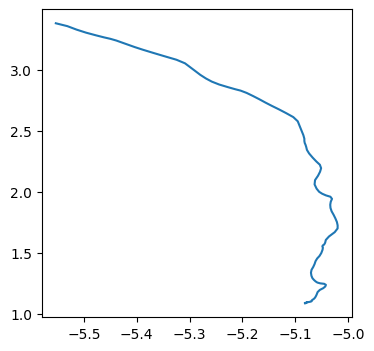

In [51]:
fig = plt.figure(figsize=(4,4))
plt.plot(trans_ext[:,0].numpy(), trans_ext[:,1].numpy())


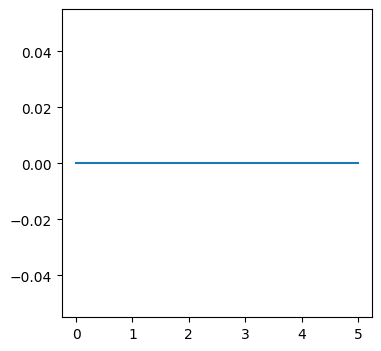

In [55]:
fig = plt.figure(figsize=(4,4))
plt.plot(trans_ext[:,0].numpy(), trans_ext[:,1].numpy())


In [31]:
import time
start = time.time()
for i in range(100):
    loss , logits = motion_gen(inputs["motion"] , conditions, return_logits=True)
end = time.time()
print('nn attention took {} seconds'.format(end - start))

nn attention took 1.8568298816680908 seconds


In [ ]:
input_mask = inputs["motion"][1]
motions_ids = inputs["motion"][0].cuda()
B, K, T = motions_ids.shape

In [ ]:
motions_ids.shape

In [109]:
gen_motion = bkn_to_motion(motions_ids, train_ds.datasets[0])

NameError: name 'bkn_to_motion' is not defined

In [ ]:
train_ds.datasets[0].render_hml(
                    gt_motion[1].detach().squeeze().cpu(),
                    "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/gt_motion_recon.gif"
                )

In [82]:
raw_audio = "/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/beat/1_wayne_0_1_1.wav"
raw_audio2 = "/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/choreomaster/0071.wav"

In [83]:
_, conditions = condition_provider(raw_audio= raw_audio, raw_text="a person speaking")
_, neg_conditions = condition_provider(raw_text="")

In [84]:

gen_ids = motion_gen.generate(conditions = conditions, neg_conditions = None, duration_s = 4, temperature = 0.2 ,timesteps=18, cond_scale = 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 42.96it/s]


In [85]:
# _, conditions = condition_provider(raw_audio= raw_audio2)
gen_motion = bkn_to_motion(gen_ids, train_ds.datasets[0])
train_ds.datasets[0].render_hml(
                    gen_motion,
                    "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/gen_novel.gif"
                )

In [13]:
from utils.motion_processing.quaternion import qinv, qrot, quaternion_to_cont6d
import utils.rotation_conversions as geometry

In [33]:
mot = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/idea400/subset_0056/Walking_And_Snapping_At_The_Same_Time.npy")

In [67]:
pose = torch.Tensor(np.load("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/smplx_322/idea400/subset_0056/Walking_And_Snapping_At_The_Same_Time.npy"))

In [34]:

def recover_root_rot_pos(data):
    rot_vel = data[..., 0]
    r_rot_ang = torch.zeros_like(rot_vel).to(data.device)
    """Get Y-axis rotation from rotation velocity"""
    r_rot_ang[..., 1:] = rot_vel[..., :-1]
    r_rot_ang = torch.cumsum(r_rot_ang, dim=-1)

    r_rot_quat = torch.zeros(data.shape[:-1] + (4,)).to(data.device)
    r_rot_quat[..., 0] = torch.cos(r_rot_ang)
    r_rot_quat[..., 2] = torch.sin(r_rot_ang)

    r_pos = torch.zeros(data.shape[:-1] + (3,)).to(data.device)
    data = data.to(torch.float)
    r_pos[..., 1:, [0, 2]] = data[..., :-1, 1:3]
    """Add Y-axis rotation to root position"""
    r_pos = qrot(qinv(r_rot_quat), r_pos)

    r_pos = torch.cumsum(r_pos, dim=-2)

    r_pos[..., 1] = data[..., 3]
    return r_rot_quat, r_pos

In [35]:
r_rot_quat, r_pos = recover_root_rot_pos(torch.Tensor(mot))

In [70]:
root_orient=pose[:, :3]
rq = geometry.axis_angle_to_quaternion(root_orient)

NameError: name 'geometry' is not defined

In [20]:
rm = geometry.quaternion_to_matrix(r_rot_quat)

In [21]:
points = r_pos[:,[0,2]]
orientations = rm

In [36]:
def quaternion_to_angle_axis(q):
    """
    Convert quaternion to angle-axis representation.
    """
    q0, q1, q2, q3 = q
    angle = 2 * np.arccos(q0)
    axis = np.array([q1, q2]) / np.sqrt(1 - q0**2)
    return angle, axis

def visualize_orientations_2d(points, orientations):
    plt.figure(figsize=(8, 6))

    # Plot points
    plt.scatter(points[:, 0], points[:, 1], c='b', marker='o', label='Points')

    # Plot orientation vectors
    for i in range(len(points)):
        origin = points[i]
        orientation_quaternion = orientations[i]
        angle, axis = quaternion_to_angle_axis(orientation_quaternion)
        dx, dy = axis * angle
        plt.quiver(*origin, dx, dy, scale=1, width = 0.004, color='r')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Orientation Visualization in 2D')
    plt.legend()
    plt.grid()
    plt.axis('equal')
    plt.show()

In [37]:
rp = r_pos[0:30,[0,2]]
rp[:,1] = -rp[:,1] 

In [38]:
r_rot_quat.shape

torch.Size([239, 4])

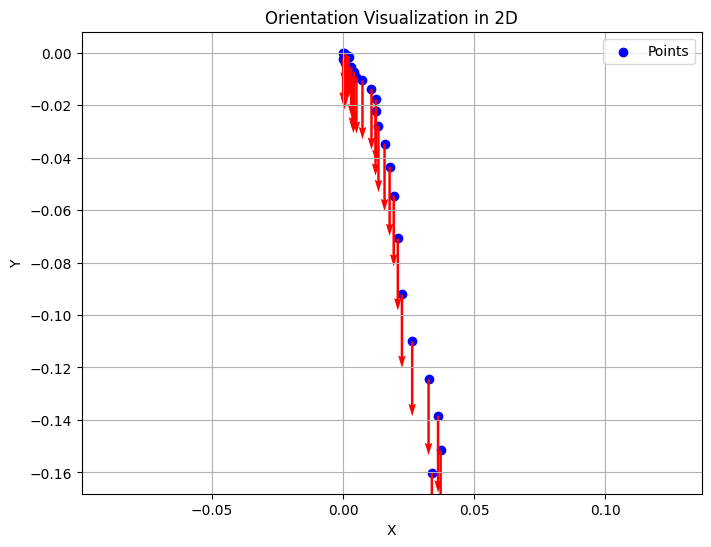

In [39]:
visualize_orientations_2d(rp, r_rot_quat)

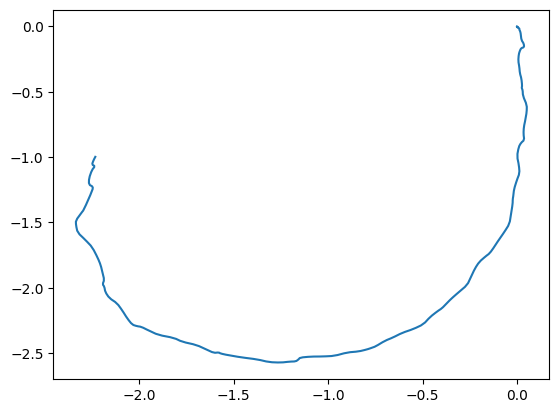

In [36]:
plt.plot(r_pos[:,0] , -r_pos[:,2]) 

### Length Estimator

In [7]:

class LengthEstimator(nn.Module):
    def __init__(self, input_size, output_size):
        super(LengthEstimator, self).__init__()
        nd = 512
        self.output = nn.Sequential(
            nn.Linear(input_size, nd),
            nn.LayerNorm(nd),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(nd, nd // 2),
            nn.LayerNorm(nd // 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(nd // 2, nd // 4),
            nn.LayerNorm(nd // 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(nd // 4, output_size),
        )

        self.output.apply(self.__init_weights)

    def __init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, text_emb):
        return self.output(text_emb)

In [43]:
out_dir = "/srv/hays-lab/scratch/sanisetty3/motionx/texts/semantic_labels_encoding/"

In [35]:
from core.datasets.text_encoders import ClipConditioner2
import clip

In [36]:
clipL = ClipConditioner2()

In [41]:
tk2 = clipL.tokenize(["a man in a hat"])
with torch.no_grad():
    embeds2, _= clipL.get_text_embedding(tk2)

In [42]:
embeds2.shape

torch.Size([1, 1, 768])

In [39]:
embeds.shape

torch.Size([1, 768])

## Motionx Cleanup

In [5]:
from glob import glob
import random

In [6]:
aist = sorted(findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/texts/semantic_labels/aist/subset_0000/"))

In [7]:
aist[0]

'/srv/hays-lab/scratch/sanisetty3/motionx/texts/semantic_labels/aist/subset_0000/Dance_Break.txt'

In [22]:
a = (sorted(glob("/srv/hays-lab/scratch/sanisetty3/music_motion/HumanMotion/AIST/texts/gBR*")))

In [25]:
a[0]

'/srv/hays-lab/scratch/sanisetty3/music_motion/HumanMotion/AIST/texts/gBR_sBM_cAll_d04_mBR0'

In [28]:
seen = set()
_ = [x for x in a if not ((prefix := x.rsplit("_" , 1)[0]) in seen or seen.add(prefix))]


In [80]:
from glob import glob

aa = (sorted(glob("/srv/hays-lab/scratch/sanisetty3/motionx/texts/semantic_labels/aist/*/*")))
seen2 = [mx.replace("texts/semantic_labels" , "motion_data/new_joint_vecs").replace("txt" , "npy") for mx in aa if "clip" not in mx ]


In [82]:
seen2

['/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/aist/subset_0000/Dance_Break.npy',
 '/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/aist/subset_0000/Dance_Break_3_Step.npy',
 '/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/aist/subset_0000/Dance_Break_6_Step.npy',
 '/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/aist/subset_0000/Dance_Break_Back_Cc.npy',
 '/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/aist/subset_0000/Dance_Break_Battle_Rock.npy',
 '/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/aist/subset_0000/Dance_Break_Cc.npy',
 '/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/aist/subset_0000/Dance_Break_Indian_Step.npy',
 '/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/aist/subset_0000/Dance_Break_Roll_Two_Step.npy',
 '/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/aist/subset_0000/Dance_Brea

In [89]:
from core.datasets.base_dataset import BaseMotionDataset
base_dset = BaseMotionDataset()

In [87]:
for pth in tqdm(seen2):
    mot = np.load(pth)
    
    base_dset.render_hml(mot , save_path = f"/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/aist/{os.path.basename(pth).replace('npy' , 'gif')}")

100%|██████████████████████████████████████████████████████████████████████████████████████████| 97/97 [34:00<00:00, 21.03s/it]


In [90]:
a = (sorted(glob("/srv/hays-lab/scratch/sanisetty3/motionx/texts/semantic_labels/aist/subset_0001/*")))

In [269]:
aa = (sorted(glob("/srv/hays-lab/scratch/sanisetty3/motionx/texts/semantic_labels/aist/subset_0004/*")))
seen2 = [os.path.basename(mx) for mx in aa if "clip" not in mx ]


In [270]:
seen2

['Dance_Krump_Arm_Swing.txt',
 'Dance_Krump_Bang_Outs.txt',
 'Dance_Krump_Buck_Hop.txt',
 'Dance_Krump_Chest_Pops.txt',
 'Dance_Krump_Focus.txt',
 'Dance_Krump_Jabs.txt',
 'Dance_Krump_Kick_Back.txt',
 'Dance_Krump_Stomp.txt',
 'Dance_Krump_Tick.txt',
 'Dance_Krump_Whip.txt',
 'Dance_Street_Jazz.txt',
 'Dance_Street_Jazz_Chasse.txt',
 'Dance_Street_Jazz_Contraction.txt',
 'Dance_Street_Jazz_Jump.txt',
 'Dance_Street_Jazz_Paddbre.txt',
 'Dance_Street_Jazz_Plie.txt',
 'Dance_Street_Jazz_Positions_Des_Bras.txt',
 'Dance_Street_Jazz_Positions_Des_Pieds.txt']

In [271]:
dnce = seen2[0]
print(dnce)
aist1 = sorted(glob(f"/srv/hays-lab/scratch/sanisetty3/motionx/texts/semantic_labels/aist/subset_0004/{dnce.split('.')[0]}*"))
print(len(aist1))
aist1[0]


Dance_Krump_Arm_Swing.txt
16


'/srv/hays-lab/scratch/sanisetty3/motionx/texts/semantic_labels/aist/subset_0004/Dance_Krump_Arm_Swing.txt'

In [272]:
cat '/srv/hays-lab/scratch/sanisetty3/motionx/texts/semantic_labels/aist/subset_0004/Dance_Krump_Arm_Swing.txt'

A person performs a Dance Krump Arm Swing.

In [268]:
mod = ["doing Street Jazz dancing with ballet Tendu steps." , \
       "performing a Street Jazz dance with the leg is extended to the front, side, or rear." , ]
for pth in tqdm(aist1):
    with open(pth , "r+") as f:
        line = str(f.readline())
        f.seek(0)
        print(line)
        if "group" in line.lower():
            line = "People are " + random.choice(mod)
        elif "woman" in line.lower() or "girl" in line.lower():
            line = "A women is " + random.choice(mod)
        elif "man" in line.lower() or "guy" in line.lower() or "boy" in line.lower():
            line = "A man is " + random.choice(mod)
        elif "person" in line.lower():
            line = "Someone is " + random.choice(mod)
        else:
            line = "A dancer is " + random.choice(mod)
    
        f.write(line)
        f.truncate()
        f.close()

    


 20%|██████████████████▏                                                                        | 4/20 [00:00<00:00, 37.08it/s]

A woman performs a Dance Street Jazz Tendu
A woman is performing a Dance Street Jazz Tendu.
A woman performs a Street Jazz Tendu dance move.
The person performs a dance move called Street Jazz Tendu.
A woman is performing a Street Jazz Tendu dance.
A woman is performing a Street Jazz Tendu dance move.
A woman is performing the Dance Street Jazz Tendu.
The dancer performs the Street Jazz Tendu step.
The guy is dancing a Street Jazz Tendu.


 75%|███████████████████████████████████████████████████████████████████▌                      | 15/20 [00:00<00:00, 47.59it/s]

A woman performs a Dance Street Jazz Tendu.
A woman is performing a Dance Street Jazz Tendu.
Someone is dancing a Street Jazz Tendu.
A woman is performing a Street Jazz Tendu dance move.
A woman performs a Street Jazz Tendu dance.
A woman is doing the Street Jazz Tendu dance.
The woman performs the Dance Street Jazz Tendu.
A woman performs a Street Jazz Tendu dance move.
Someone is performing the Dance Street Jazz Tendu.
A woman is performing a Street Jazz Tendu dance move.
A boy is performing a Street Jazz Tendu dance move.


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 46.94it/s]


## Streaming transformer

In [ ]:

from core.param_dataclasses import pattern_providers
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.utils import instantiate_from_config, get_obj_from_str


In [ ]:
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider,ConditionFuserStreamer
from core.models.generation.lm import LMModel, MotionGen
import einops

In [ ]:
gen_cfg = strm_get_cfg_defaults()
gen_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_streaming/motion_streaming.yaml")
gen_cfg.freeze()

In [ ]:
lm_args = gen_cfg.transformer_lm
target = lm_args.pop("target")
fuse_config = gen_cfg.fuser
pattern_args = gen_cfg.codebooks_pattern
dataset_args = gen_cfg.dataset

In [ ]:
model_gen= MotionGen(lm_args , fuse_config , pattern_args ).to(device)
model_gen = model_gen.eval()

In [ ]:
modeling = pattern_args.pop("modeling")
pattern_provider = pattern_providers[modeling](lm_args.n_q, delays = pattern_args.delays , flatten_first = pattern_args.flatten_first , empty_initial = pattern_args.empty_initial )

In [ ]:
fuse_method = fuse_config.pop("fuse_method")


In [ ]:
fuse_method = {'cross': ['text'], 'input_interpolate': ['audio']}

In [ ]:
if isinstance(fuse_method, list):
    fuse_method = fuse_method[0]
condition_fuser = ConditionFuserStreamer(fuse_method, **fuse_config)

In [ ]:
model = LMModel(
            pattern_provider=pattern_provider,
            fuser=condition_fuser,
            **lm_args
        ).to(device)

In [ ]:
condition_provider = ConditionProvider(
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            audio_padding=dataset_args.audio_padding,
            motion_max_length_s=10,
            audio_max_length_s=10,
            pad_id = model_gen.model.pad_token_id,
            fps=30/4,
            # device = "cpu"
        )

In [ ]:
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
# dset = MotionIndicesAudioTextDataset("beat" , "/srv/hays-lab/scratch/sanisetty3/motionx" ,motion_rep = "full", split = "render" , fps = 30/4  )


In [ ]:
train_ds, sampler_train, weights_train  = load_dataset_gen(dataset_names = ["humanml"] , dataset_args=dataset_args, split = "test")
train_loader = torch.utils.data.DataLoader(
        train_ds,
        1,
        # sampler=sampler_train,
        # shuffle = False,
        collate_fn=partial(simple_collate , conditioner = condition_provider , permute = True),
        # drop_last=True,
    )

In [ ]:
for inputs, conditions in train_loader:
    break
    

In [ ]:
train_ds.datasets[0].fps

In [ ]:
for inputs, conditions in train_loader:
    input_mask = inputs["motion"][1]
    motions_or_ids = inputs["motion"][0]
    if motions_or_ids.shape[-1] < 1: 
        print(input_mask.shape , motions_or_ids.shape )
    

In [ ]:
inputs["names"]

In [ ]:
input_mask = inputs["motion"][1]
motions_or_ids = inputs["motion"][0].cuda()
B, K, T = motions_or_ids.shape

In [ ]:
motions = inputs["motion"][0].squeeze().to(torch.long)
motion_mask = inputs["motion"][1]


In [ ]:
motions.shape

In [ ]:
conditions["text"][0].shape

In [ ]:
conditions["audio"][0].shape

In [ ]:
conditions["audio"][1]

In [ ]:
cond = conditions["audio"][0]
cond_mask = conditions["audio"][1]
cond = einops.rearrange(cond, "b t d -> b d t")
cond = F.interpolate(cond, size=52)
cond_mask = (
    F.interpolate(
        cond_mask.unsqueeze(1).to(torch.float),
        size=52,
    )
    .squeeze(1)
    .to(torch.bool)
)

In [ ]:
out = model_gen((motions, motion_mask), conditions)

In [ ]:
B , N , C = conditions["audio"][0].shape

In [ ]:
out = model.compute_predictions(inputs["motion"] , conditions)

In [ ]:
audio_embed = model.project_audio(conditions["audio"][0])
text_embed = model.project_text(conditions["text"][0])

In [ ]:
audio_embed.shape

In [ ]:
input_ = sum([model.emb[k](motions_or_ids[:, k]) for k in range(K)])

In [ ]:
motions.shape

## VIusalise motions

In [ ]:
def bkn_to_motion(codes, dset):
        # codes b k n
        body_inds = codes[:, 0]
        left_inds = codes[:, 1]
        right_inds = codes[:, 2]
        body_motion = body_model.decode(body_inds[0:1]).detach().cpu()
        left_motion = left_hand_model.decode(left_inds[0:1]).detach().cpu()
        right_motion = right_hand_model.decode(right_inds[0:1]).detach().cpu()
        body_M = dset.toMotion(
            body_motion[0],
            motion_rep=MotionRep(body_cfg.dataset.motion_rep),
            hml_rep=body_cfg.dataset.hml_rep,
        )
        left_M = dset.toMotion(
            left_motion[0],
            motion_rep=MotionRep(left_cfg.dataset.motion_rep),
            hml_rep=left_cfg.dataset.hml_rep,
        )
        right_M = dset.toMotion(
            right_motion[0],
            motion_rep=MotionRep(right_cfg.dataset.motion_rep),
            hml_rep=right_cfg.dataset.hml_rep,
        )
        full_M = dset.to_full_joint_representation(body_M, left_M, right_M)

        return full_M

In [ ]:
for inputs, conditions in train_loader:
    break
    

In [ ]:
dset = train_ds.datasets[0]

In [ ]:
body_inds = motions_or_ids[:,0]
left_inds = motions_or_ids[:,1]
right_inds = motions_or_ids[:,2]
body_motion = body_model.decode(body_inds[0:1]).detach()
left_motion = left_hand_model.decode(left_inds[0:1]).detach()
right_motion = right_hand_model.decode(right_inds[0:1]).detach()
body_M = dset.toMotion(body_motion[0] , motion_rep = MotionRep(body_cfg.dataset.motion_rep) , hml_rep = body_cfg.dataset.hml_rep , )
left_M = dset.toMotion(left_motion[0] , motion_rep = MotionRep(left_cfg.dataset.motion_rep) , hml_rep = left_cfg.dataset.hml_rep , )
right_M = dset.toMotion(right_motion[0] , motion_rep = MotionRep(right_cfg.dataset.motion_rep) , hml_rep = right_cfg.dataset.hml_rep , )
full_M = dset.to_full_joint_representation(body_M , left_M , right_M )

In [ ]:
motion.device

In [ ]:
motion = inputs["motion"][0]

In [ ]:
gt_motion = bkn_to_motion(motion, dset)

In [ ]:
gt_motion.velocity.shape

In [ ]:
# dset.render_hml(gt_motion , "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/full_joined.gif", from_rotation = True)

In [ ]:
inputs["motion"][0].shape

In [ ]:
body_inds = motions_or_ids[:,0]
body_motion = body_model.decode(body_inds[0:1]).detach()
body_M = dset.toMotion(body_motion[0] , motion_rep = MotionRep(body_cfg.dataset.motion_rep) , hml_rep = body_cfg.dataset.hml_rep , )


In [ ]:
for inputs, conditions in tqdm(train_loader):
    # print(inputs["names"][0])
    
    motion = inputs["motion"][0][...,:300]
    gt_motion = bkn_to_motion(motion, dset)
    # body_inds = motion[:,0]
    # with torch.no_grad():
    #     body_motion = body_model.decode(body_inds[0:1]).cpu()
    # body_M = dset.toMotion(body_motion[0] , motion_rep = MotionRep(body_cfg.dataset.motion_rep) , hml_rep = body_cfg.dataset.hml_rep , )

    dset.render_hml(gt_motion , f"/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/all/{os.path.basename(inputs['names'][0])}.gif", from_rotation = True)
    


In [ ]:
body_M.hml_rep

In [ ]:
choreo = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/choreomaster/1160.npy")
full_og = dset.toMotion(choreo , motion_rep = MotionRep("full") , hml_rep = "gprvc" )
xyz = dset.to_xyz(full_og, from_rotation=True).cpu()

In [ ]:
import utils.vis_utils.plot_3d_global as plot_3d
plot_3d.render(
            np.array(xyz)[:300],
            "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/full_og.gif",
        )

In [ ]:
choreo.shape

In [ ]:
full_M = dset.inv_transform(full_M)
full_M.tensor()
full_M.root_params = full_og.root_params[:full_M.rotations.shape[0]]
xyz_ = dset.to_xyz(full_M, from_rotation=True).cpu()

In [ ]:
xyz_.shape

In [ ]:

plot_3d.render(
            np.array(xyz_)[:300],
            "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/full_joined.gif",
        )

In [ ]:
null_conditions = model.cfg_dropout(conditions, 1.0)

In [ ]:
out = model.compute_predictions(inputs["motion"] , conditions)

In [ ]:
model = model.eval()

In [ ]:
outt = model.generate(conditions = null_conditions , two_step_cfg =True)

In [ ]:
outt.shape

In [ ]:
import time
start = time.time()
for i in range(10):
    outt = model.generate(conditions = conditions , two_step_cfg =True)
end = time.time()
print('custom attention took {} seconds'.format(end - start))

In [ ]:
import time
start = time.time()
for i in range(10):
    outt = model.generate(conditions = conditions , two_step_cfg =True)
end = time.time()
print('custom attention without flash took {} seconds'.format(end - start))

In [ ]:
import time
start = time.time()
for i in range(10):
    outt = model.generate(conditions = conditions , two_step_cfg =True)
end = time.time()
print('torch attention took {} seconds'.format(end - start))

In [ ]:
model_cfg = cfg_s.transformer_lm

In [ ]:
params = MotionTokenizerParams(model_cfg.card)

In [ ]:
n_q = 3
codes = inputs["motion"][0].permute(0,2,1).to(torch.long)
code_mask = inputs["motion"][1]

In [ ]:
B, K, T = codes.shape
codes = codes.contiguous()

In [ ]:
codes.shape

In [ ]:
pattern = pattern_provider.get_pattern(T)

In [ ]:
pattern

In [ ]:
sequence_codes, sequence_indexes, sequence_mask = (
            pattern.build_pattern_sequence(
                codes,
                1025,
                keep_only_valid_steps=True,
            )
)

In [ ]:
sequence_codes.shape

In [ ]:
code_mask.shape

In [ ]:
sequence_mask.shape

In [ ]:
new_mask = torch.ones_like(sequence_mask).repeat(B , 1 , 1)
for i in range(n_q):
    new_mask[:,i,i+1:] = code_mask[:,0:T-i]

In [ ]:
new_mask.shape

In [ ]:
new_new_mask = (new_mask.sum(1) == new_mask.shape[1])

In [ ]:
new_new_mask[0]

In [ ]:
from core.datasets.audio_encoders import EncodecConditioner

In [ ]:
audio_list = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/")

In [ ]:
audenc = EncodecConditioner(target_sr = 9600)
# audlib = AudioConditionerLibrosa()

In [ ]:
for src in tqdm(audio_list):
    embs = audenc(audio_list[0])
    np.save(src.replace("/wav" , "/encodec").replace(".wav" , ".npy") , embs.detach().cpu().numpy())

In [ ]:
audio_list[0]

In [ ]:
emb = audenc(audio_list[0])

In [ ]:
emb.shape

In [ ]:
np.load("/srv/hays-lab/scratch/sanisetty3/motionx/audio/encodec/aist/mBR0.npy").shape

In [ ]:
emb = audenc("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/choreomaster/0071.wav")

In [ ]:
emb2 = audlib("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/choreomaster/0071.wav")

In [ ]:
emb2.shape

In [ ]:
emb.shape

In [ ]:
emb1 = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/audio/encodec/choreomaster/0071.npy")

In [ ]:
emb1.shape